## Import libraries

In [2]:
import numpy as np
import cv2
from tensorflow.keras import layers
import tensorflow as tf

import os
import gdown
from zipfile import ZipFile

import matplotlib.pyplot as plt

## Load the CelebA dataset

In [2]:
os.makedirs("celeba")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba/data.zip", "r") as zipobj:
    zipobj.extractall("celeba")

## Prepair the dataset for training

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "celeba",
    label_mode=None,
    validation_split=0.05,
    subset="training",
    seed=1337,
    image_size=(128, 128),
    batch_size=64,
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "celeba",
    label_mode=None,
    validation_split=0.05,
    subset="validation",
    seed=1337,
    image_size=(128, 128),
    batch_size=64,
)


train_dataset = train_dataset.map(lambda x: x / 255.0).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x: x / 255.0).prefetch(tf.data.AUTOTUNE)

Found 202599 files belonging to 1 classes.
Using 192470 files for training.
Found 202599 files belonging to 1 classes.
Using 10129 files for validation.


### Let's see how the images look like

(64, 128, 128, 3)


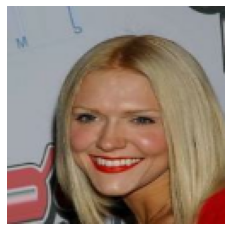

In [5]:
for x in val_dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    print(x.shape)
    break

## This is the most important part!
## Our whole VAE model

In [128]:
class VanillaVAE(tf.keras.Model):
    def __init__(self, image_shape, latent_dim):
        super(VanillaVAE, self).__init__()
        self.image_shape = image_shape
        self.latent_dim = latent_dim
        self.shape_before_flattening = None
        self.encoder = None
        self.decoder = None

        self.train_total_loss_tracker = tf.keras.metrics.Mean(
            name="train_total_loss")
        self.train_reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="train_reconstruction_loss"
        )
        self.train_kl_loss_tracker = tf.keras.metrics.Mean(
            name="train_kl_loss")

        self.test_total_loss_tracker = tf.keras.metrics.Mean(
            name="total_loss")
        self.test_reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.test_kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

        self.build_vae()

    def encoder_block(self, inputs, filters, kernel_size, strides, padding, activation, layer, use_bn=False):
        x = layers.Conv2D(filters, kernel_size, strides,
                          padding, activation=activation, name='Conv2D_'+str(layer))(inputs)
        if use_bn:
            x = layers.BatchNormalization(name='BN_'+str(layer))(x)
        return x

    def decoder_block(self, inputs, filters, kernel_size, strides, padding, activation, layer, use_bn=False):
        x = layers.Conv2DTranspose(
            filters, kernel_size, strides, padding, activation=activation, name='Conv2DTranspose_'+str(layer))(inputs)
        if use_bn:
            x = layers.BatchNormalization(name='BN_'+str(layer))(x)
        return x

    def reparameterize(self, coding):
        mu, log_var = coding
        epsilon = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(log_var * .5) * epsilon

    def build_encoder(self):
        inputs = layers.Input(shape=self.image_shape, name='Encoder_Input')
        x = self.encoder_block(inputs=inputs, filters=32, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=1, use_bn=True)
        x = self.encoder_block(inputs=x, filters=64, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=2, use_bn=True)
        x = self.encoder_block(inputs=x, filters=128, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=3, use_bn=True)
        x = self.encoder_block(inputs=x, filters=256, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=4, use_bn=True)
        x = self.encoder_block(inputs=x, filters=512, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=5, use_bn=True)
        self.shape_before_flattening = tf.keras.backend.int_shape(x)[1:]
        x = layers.Flatten(name='Flatten')(x)
        x = layers.Dense(512, activation='relu', name='Dense_Layer_6')(x)
        mu = layers.Dense(self.latent_dim, name='Dense_MU')(x)
        log_var = layers.Dense(self.latent_dim, name='Dense_Log_Var',
                               kernel_initializer=tf.keras.initializers.RandomUniform(
                                   minval=-0.08, maxval=0.08, seed=None)
                               )(x)
        z = layers.Lambda(self.reparameterize, output_shape=(
            self.latent_dim,), name='Code')([mu, log_var])

        self.encoder = tf.keras.Model(inputs, [mu, log_var, z], name='encoder')

    def build_decoder(self):
        inputs = layers.Input(shape=(self.latent_dim,), name='Decoder_Input')
        x = layers.Dense(512, activation='relu', name='Dense_Layer_7')(inputs)
        x = layers.Dense(np.prod(self.shape_before_flattening),
                         activation='relu', name='Dense_Layer_8')(x)
        x = layers.Reshape(self.shape_before_flattening,
                           name='Reshape_Layer')(x)
        x = self.decoder_block(inputs=x, filters=256, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=9, use_bn=True)
        x = self.decoder_block(inputs=x, filters=128, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=10, use_bn=True)
        x = self.decoder_block(inputs=x, filters=64, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=11, use_bn=True)
        x = self.decoder_block(inputs=x, filters=32, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=12, use_bn=True)
        x = self.decoder_block(inputs=x, filters=3, kernel_size=3,
                               strides=2, padding='same', activation='tanh', layer=13, use_bn=False)
        self.decoder = tf.keras.Model(inputs, x, name='decoder')

    def build_vae(self):
        self.build_encoder()
        self.build_decoder()

    @property
    def metrics(self):
        return [
            self.train_total_loss_tracker,
            self.train_reconstruction_loss_tracker,
            self.train_kl_loss_tracker,
            self.test_total_loss_tracker,
            self.train_reconstruction_loss_tracker,
            self.test_kl_loss_tracker
        ]

    def compute_loss(self, inputs, outputs, mu, log_var):
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(inputs - outputs), axis=(1, 2, 3)))
        # reconstruction_loss *= 0.1  # reconstruction_loss_factor

        kl_loss = -0.5 * (1 + log_var - tf.exp(log_var) - tf.square(mu))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = kl_loss + reconstruction_loss
        return total_loss, reconstruction_loss, kl_loss

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mu, log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            total_loss, reconstruction_loss, kl_loss = self.compute_loss(
                data, reconstruction, mu, log_var)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.train_total_loss_tracker.update_state(total_loss)
        self.train_reconstruction_loss_tracker.update_state(
            reconstruction_loss)
        self.train_kl_loss_tracker.update_state(kl_loss)

        return {
            'train_total_loss': self.train_total_loss_tracker.result(),
            'train_reconstruction_loss': self.train_reconstruction_loss_tracker.result(),
            'train_kl_loss': self.train_kl_loss_tracker.result()
        }

    def test_step(self, data):
        mu, log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        total_loss, reconstruction_loss, kl_loss = self.compute_loss(
            data, reconstruction, mu, log_var)
        self.test_total_loss_tracker.update_state(total_loss)
        self.test_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.test_kl_loss_tracker.update_state(kl_loss)

        return {
            'total_loss': self.test_total_loss_tracker.result(),
            'reconstruction_loss': self.test_reconstruction_loss_tracker.result(),
            'kl_loss': self.test_kl_loss_tracker.result()
        }

    def sample(self, count=1, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(count, self.latent_dim))
        return self.decoder(eps)


## Let's create and compile our model and see the architecture

In [129]:
vae = VanillaVAE(image_shape=(128, 128, 3), latent_dim=128)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

In [27]:
# Encoder architecture
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_Input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2D_1 (Conv2D)              (None, 64, 64, 32)   896         ['Encoder_Input[0][0]']          
                                                                                                  
 BN_1 (BatchNormalization)      (None, 64, 64, 32)   128         ['Conv2D_1[0][0]']               
                                                                                                  
 Conv2D_2 (Conv2D)              (None, 32, 32, 64)   18496       ['BN_1[0][0]']             

In [28]:
# Decoder architecture
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Decoder_Input (InputLayer)  [(None, 128)]             0         
                                                                 
 Dense_Layer_7 (Dense)       (None, 512)               66048     
                                                                 
 Dense_Layer_8 (Dense)       (None, 8192)              4202496   
                                                                 
 Reshape_Layer (Reshape)     (None, 4, 4, 512)         0         
                                                                 
 Conv2DTranspose_9 (Conv2DTr  (None, 8, 8, 256)        1179904   
 anspose)                                                        
                                                                 
 BN_9 (BatchNormalization)   (None, 8, 8, 256)         1024      
                                                           

## TRAIN :))

In [ ]:
with tf.device('/device:GPU:0'):
  history = vae.fit(train_dataset, epochs=20, batch_size=64, shuffle=True, validation_data=val_dataset)

## Always save your trained model

In [ ]:
vae.encoder.save('vae_encoder')
vae.decoder.save('vae_decoder')

In [ ]:
# Run to load the weights back in to the model
vae.encoder.load_weights('vae_encoder/variables/variables')
vae.decoder.load_weights('vae_decoder/variables/variables')

## Let's see how it turned out...


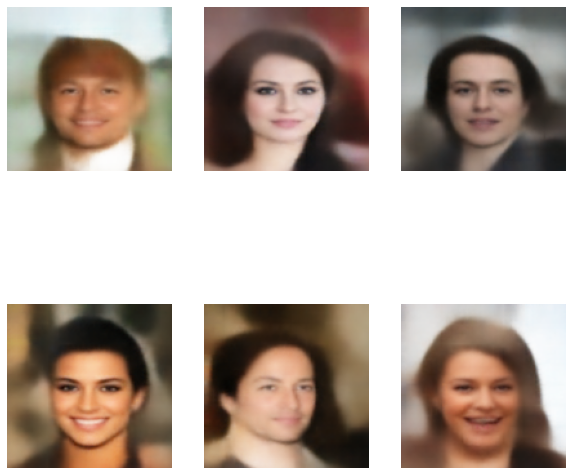

In [112]:
# Generate 6 faces tha do not exist
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10., 10.)) 

for ax in axes.flat:
    sample = vae.sample(eps=tf.expand_dims(tf.random.normal(shape=(128,)), 0))
    img= (sample.numpy() * 255).astype("int32")[0]
    ax.imshow(img)
    ax.axis('off')

### TADAAA... You just generated faces that don't exist
Alghough the images are not so realistic, but it's a good start.

Try training longer and tweak the hyperparameters.